In [1]:
# -- IMPORTS START --
import pandas as pd
import glob
import re
import os
import sys
import pickle
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from sklearn import tree, metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from scipy.signal import butter, filtfilt, find_peaks
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.model_selection import train_test_split

import datetime
# -- IMPORTS END --

# enable zooming into graphs

plt.rcParams['figure.figsize'] = [9, 6] # width, height in inches

### Helper Functions:

**unix_to_date:**
- Converts Epoch(Unix) Time into traditional DateTime information

**starter/starter_g:**
- applies all necessary cleaning to eliminate null instances, unnecessary columns, etc.
- returns working DataFrame with relevant information

**calc_magnitude**
- Takes individual(x,y,z) accelerometer information and combines it into a singular magnitude

**combine**
- Takes acceleration dataframe and combines it with gyroscope dataframe 

In [2]:
def unix_to_date(x):
    f = float(x)/10**9
    full = datetime.datetime.fromtimestamp(f)
    return full


In [3]:
def calc_magnitude(data):

    # Calculate magnitude  
    data['accel_mag'] = np.sqrt(data['x']**2 + data['y']**2 + data['z']**2) # absolute accel magnitude
    data['accel_mag'] = data['accel_mag'] 

    return data

In [4]:
def starter(filepath):
    df = pd.read_csv(filepath, dtype={'time': 'float64'})
    df.dropna(inplace=True)
    df['time'] = df['time'].apply(unix_to_date)
    df = df.drop(['seconds_elapsed'], axis=1)
    df = df.reindex(columns=['time', 'x', 'y', 'z'])

    return df

In [5]:
def starter_g(filepath):
    df = pd.read_csv(filepath, dtype={'time': 'float64'})
    df.dropna(inplace=True)
    df['time'] = df['time'].apply(unix_to_date)
    df.rename(columns={'x': 'x_gyro'},inplace=True)
    df.rename(columns={'y': 'y_gyro'},inplace=True)
    df.rename(columns={'z': 'z_gyro'},inplace=True)

    df = df.drop(['seconds_elapsed'], axis=1)
    df = df.reindex(columns=['time', 'x_gyro', 'y_gyro', 'z_gyro'])

    return df

In [6]:
def combine(acg,gyro):
    combined_df = pd.merge(acg,gyro,on="time",how='left')
    combined_df.drop_duplicates(subset=acg, inplace=True)
    combined_df = combined_df.dropna()
    return combined_df



In [7]:
def add_features(window):
    features = {}
    features['avg'] = window['accel_mag'].mean()
    features['max'] = window['accel_mag'].quantile(1)
    features['med'] = window['accel_mag'].quantile(0.5)
    features['min'] = window['accel_mag'].quantile(0)
    features['q25'] = window['accel_mag'].quantile(0.25)
    features['q75'] = window['accel_mag'].quantile(0.75)
    features['std'] = window['accel_mag'].std()
    df = pd.DataFrame([features])
    return df

In [8]:
def train_decision_tree(frames):
    # Extract feature columns 
    X = frames[['avg', 'max', 'med', 'min', 'q25', 'q75', 'std']]

    # Extract target column
    y = frames['activity']

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 

    # Create model
    dt_model = DecisionTreeClassifier(criterion='entropy',max_depth=5).fit(X_train, y_train)
    dt_pred = dt_model.predict(X_test)

    # Evaluate on test set
    acc = dt_model.score(X_test, y_test)
    dt_cm = confusion_matrix(y_test, dt_pred, labels=dt_model.classes_)
    print(classification_report(y_test, dt_pred))
    print("Accuracy on test set:", acc)

    return dt_model,dt_cm,acc

In [42]:
#Do not modify
def remove_noise(data,sampling_rate):
    from scipy.signal import butter, filtfilt, find_peaks

    # Low pass filter
    cutoff = 5 # Hz
    order = 2
    b, a = butter(order, cutoff/(sampling_rate/2), btype='lowpass')
    data['filtered_accel_mag'] = filtfilt(b, a, data['accel_mag'])

    return data

### _________________________________________________
### Reading Training Information

In [29]:
b_a = starter("data/Backhand/Accelerometer.csv")
calc_magnitude(b_a)
f_a = starter("data/Forehand/Accelerometer.csv")
calc_magnitude(f_a)
s_a = starter("data/Serve/Accelerometer.csv")
calc_magnitude(s_a)

b_g = starter_g("data/Backhand/Gyroscope.csv")
f_g = starter_g("data/Forehand/Gyroscope.csv")
s_g = starter_g("data/Serve/Gyroscope.csv")

In [30]:
b_a.head()

,time,x,y,z,accel_mag
0,2023-12-05 11:13:39.721843,-2.377742,4.992181,2.916734,6.251629
1,2023-12-05 11:13:39.731797,-2.521449,5.197489,2.800269,6.419743
2,2023-12-05 11:13:39.741750,-2.326290,5.545609,2.453425,6.494975
3,2023-12-05 11:13:39.751703,-2.049193,5.907633,2.005502,6.566685
4,2023-12-05 11:13:39.761656,-1.828922,6.161450,1.601801,6.623759


In [31]:
b_g.head()

,time,x_gyro,y_gyro,z_gyro
0,2023-12-05 11:13:39.721843,1.495890,-1.203373,0.554987
1,2023-12-05 11:13:39.731797,1.364633,-1.271482,0.476789
2,2023-12-05 11:13:39.741750,1.314309,-1.339765,0.414898
3,2023-12-05 11:13:39.751703,1.328773,-1.371694,0.373015
4,2023-12-05 11:13:39.761656,1.403920,-1.379471,0.359779


### ______________________________
### Swing Data Visualization

In [32]:
def multi_plottera(df):
    plt.plot(df['time'], df['x'],label="X")
    plt.plot(df['time'],df['y'],label="Y")
    plt.plot(df['time'],df['z'],label="Z")
    plt.legend()
    plt.show()
    



In [33]:
def multi_plotterg(df):
    plt.plot(df['time'], df['x_gyro'],label="X")
    plt.plot(df['time'],df['y_gyro'],label="Y")
    plt.plot(df['time'],df['z_gyro'],label="Z")
    plt.legend()
    plt.show()
    

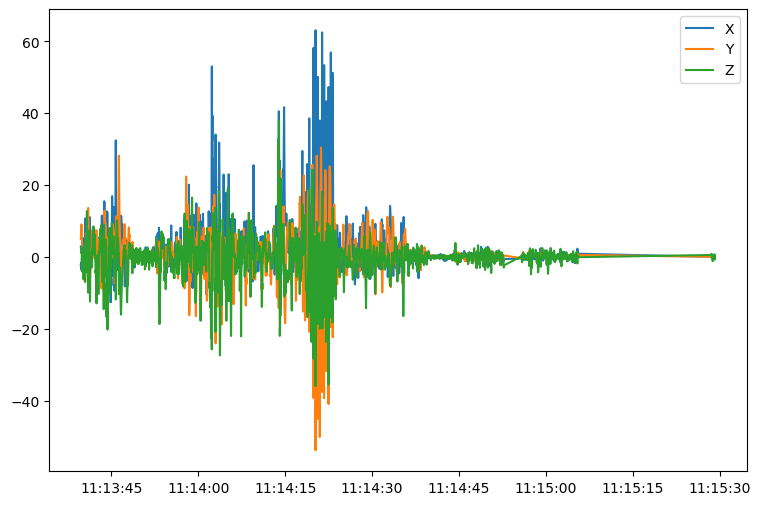

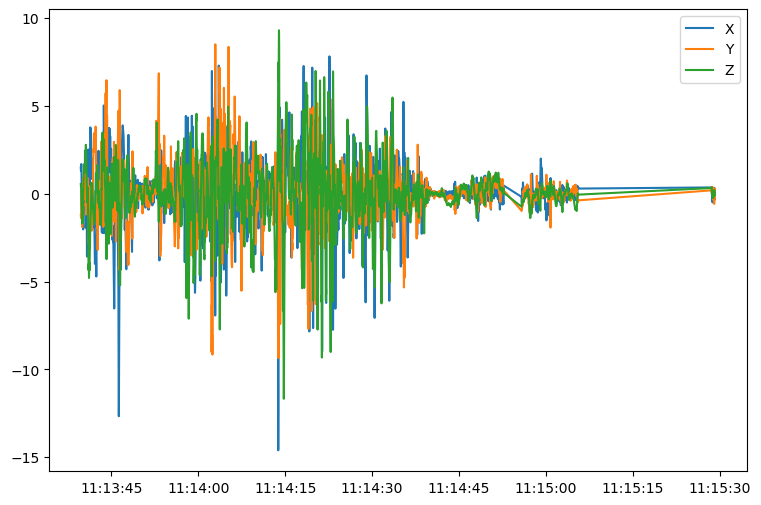

In [34]:
multi_plottera(b_a)
multi_plotterg(b_g)

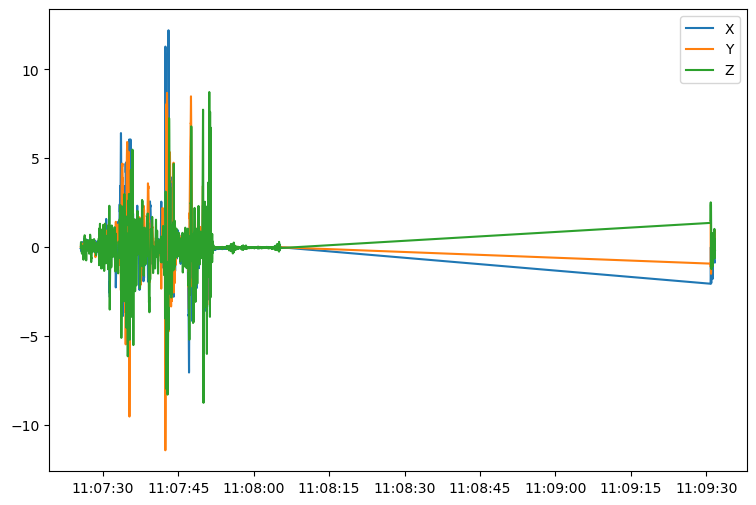

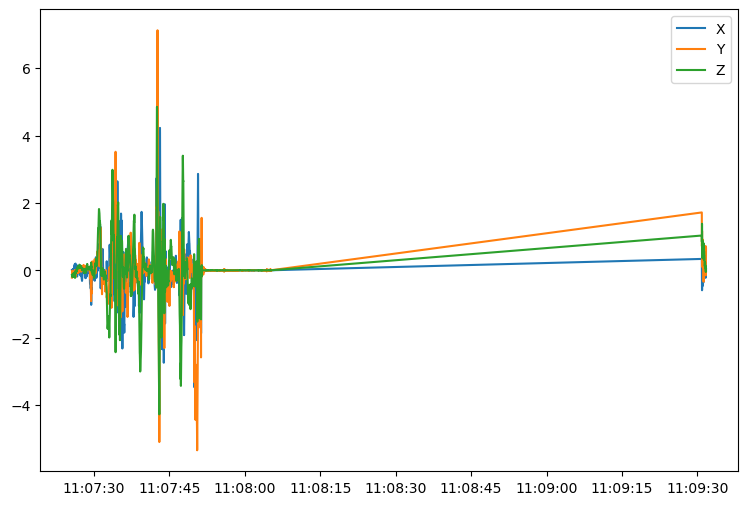

In [35]:
multi_plottera(f_a)
multi_plotterg(f_g)

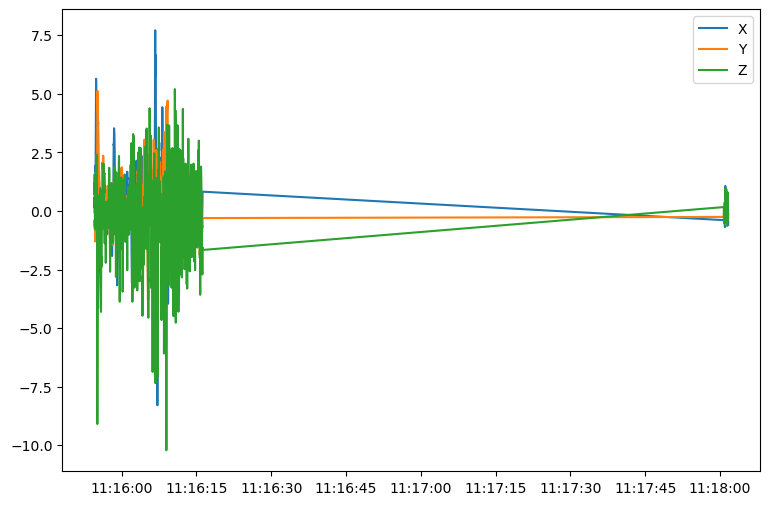

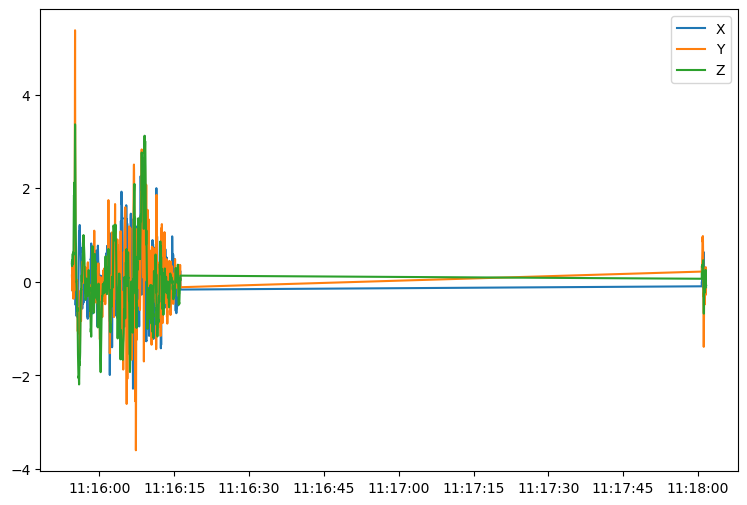

In [36]:
multi_plottera(s_a)
multi_plotterg(s_g)

### ________________________________


In [37]:
print(b_a.shape)
b_g.shape

(8387, 5)


(8387, 4)

In [46]:
backhand_df = combine(b_a,b_g)
forehand_df = combine(f_a,f_g)
serve_df = combine(s_a,s_g)


In [39]:
backhand_df.head()

,time,x,y,z,accel_mag,x_gyro,y_gyro,z_gyro
0,2023-12-05 11:13:39.721843,-2.377742,4.992181,2.916734,6.251629,1.495890,-1.203373,0.554987
1,2023-12-05 11:13:39.731797,-2.521449,5.197489,2.800269,6.419743,1.364633,-1.271482,0.476789
2,2023-12-05 11:13:39.741750,-2.326290,5.545609,2.453425,6.494975,1.314309,-1.339765,0.414898
3,2023-12-05 11:13:39.751703,-2.049193,5.907633,2.005502,6.566685,1.328773,-1.371694,0.373015
4,2023-12-05 11:13:39.761656,-1.828922,6.161450,1.601801,6.623759,1.403920,-1.379471,0.359779


In [47]:
clean_backhand_df = remove_noise(backhand_df,500)
clean_forehand_df = remove_noise(forehand_df,500)
clean_serve_df = remove_noise(serve_df,500)

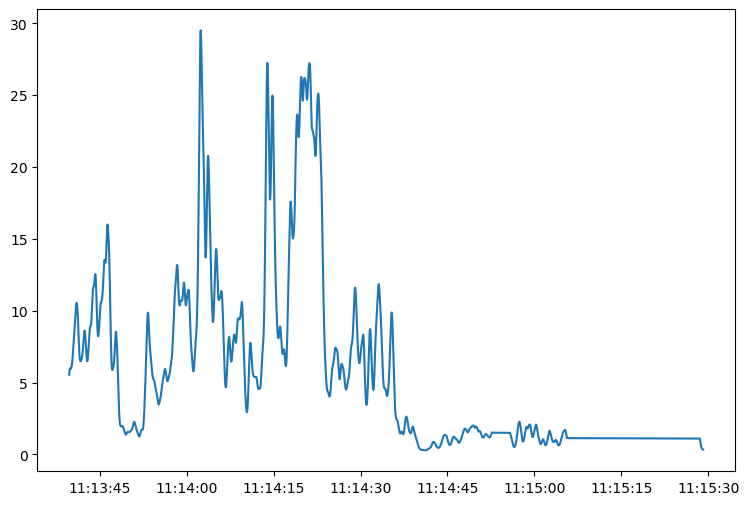

In [48]:
plt.plot(clean_backhand_df['time'],clean_backhand_df['filtered_accel_mag'])

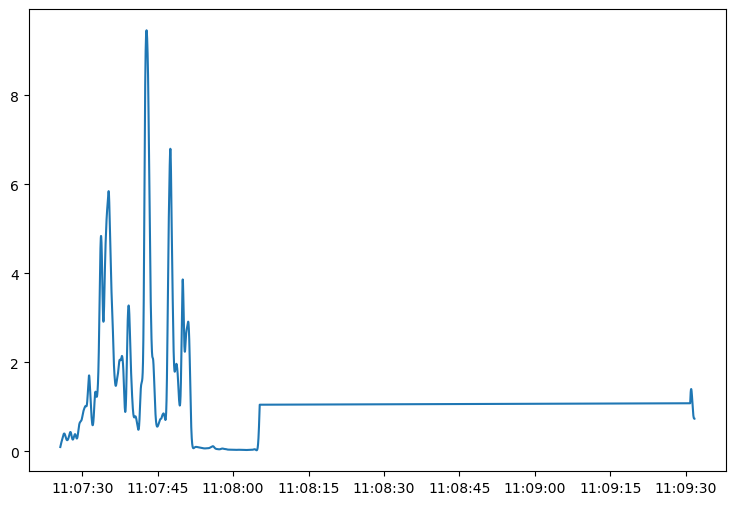

In [49]:
plt.plot(clean_forehand_df['time'],clean_forehand_df['filtered_accel_mag'])

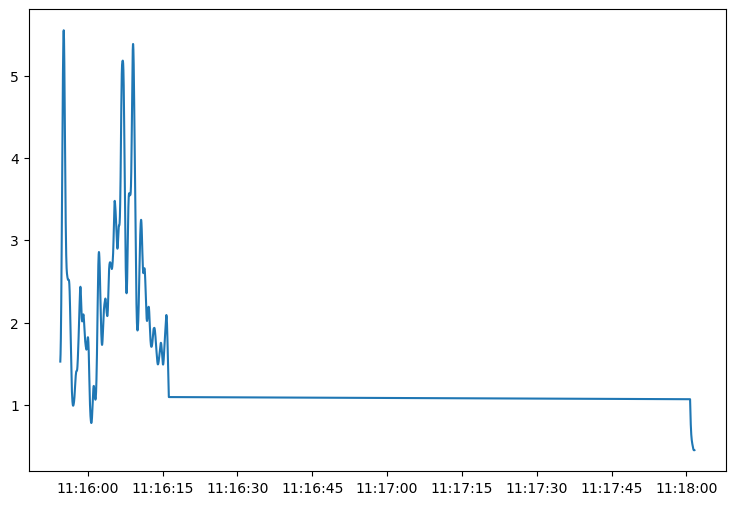

In [50]:
plt.plot(clean_serve_df['time'],clean_serve_df['filtered_accel_mag'])